# 2.0 Segmentation Net(Segnet)

![pic](https://drive.google.com/uc?id=1xTvYLmPfRvNzQ9LdGZR3YLAfjI5pZgwk)

**References-**
- https://github.com/imlab-uiip/keras-segnet
- https://arxiv.org/pdf/1505.04366.pdf

In [0]:
def two_conv2d_blocks(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function containing 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
def single_conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function containing 1 convolutional layer with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
def get_segnet(input_img, n_filters, dropout, batchnorm):
    
    """Function to define the Segnet architecture"""
    
    # Encoder Path
    c1 = two_conv2d_blocks(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = two_conv2d_blocks(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = two_conv2d_blocks(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    c3_1 = single_conv2d_block(c3, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3_1)
    p3 = Dropout(dropout)(p3)
    
    c4 = two_conv2d_blocks(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    c4_1= single_conv2d_block(c4, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4_1)
    p4 = Dropout(dropout)(p4)
    
    c5 = two_conv2d_blocks(p4, n_filters = n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    c5_1= single_conv2d_block(c5, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p5 = MaxPooling2D((2, 2))(c5_1)
    p5 = Dropout(dropout)(p5)    
    
    # Decoder Path
    u6 = UpSampling2D()(p5)
    c6 = two_conv2d_blocks(u6,n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    c6 = single_conv2d_block(c6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    c6 = Dropout(dropout)(c6)
    
    u7 = UpSampling2D()(c6)
    c7 = two_conv2d_blocks(u7,n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    c7 = single_conv2d_block(c7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    c7 = Dropout(dropout)(c7)
    
    u8 = UpSampling2D()(c7)
    c8 = two_conv2d_blocks(u8,n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    c8 = single_conv2d_block(c8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    c8 = Dropout(dropout)(c8)
    
    u9 = UpSampling2D()(c8)
    c9 = single_conv2d_block(u9,n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    c9 = single_conv2d_block(c9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    c9 = Dropout(dropout)(c9)
    
    u10 = UpSampling2D()(c9)
    c10 = single_conv2d_block(u10,n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    c10 = Dropout(dropout)(c10)
    
    outputs = Conv2D(4, (1, 1), activation='sigmoid')(c10)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
input_img = Input((128,800,3),name='img')
model = get_segnet(input_img, n_filters=16, dropout=0.5, batchnorm=True)
model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[dice_coef])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 128, 800, 3)       0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 128, 800, 16)      448       
_________________________________________________________________
batch_normalization_76 (Batc (None, 128, 800, 16)      64        
_________________________________________________________________
activation_76 (Activation)   (None, 128, 800, 16)      0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 128, 800, 16)      2320      
_________________________________________________________________
batch_normalization_77 (Batc (None, 128, 800, 16)      64        
_________________________________________________________________
activation_77 (Activation)   (None, 128, 800, 16)      0   

## 2.1 Checkpointing the model and creating the callback list

In [0]:
tbc=TensorBoardColab()
mc = ModelCheckpoint('best_model_segnet.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
callbacks_list = [mc, TensorBoardColabCallback(tbc)]

Wait for 8 seconds...
TensorBoard link:
http://513dcfc3.ngrok.io


## 2.2 Fitting the train data and validation

In [0]:
train_batches = Train_DataGenerator(train_data,shuffle=True)
valid_batches = Val_DataGenerator(cv_data)
history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = 30, verbose=1,
                              class_weight=class_wts, callbacks = callbacks_list)





Epoch 1/30
667/667 [==============================] - 263s 395ms/step - loss: 1.0959 - dice_coef: 0.0619 - val_loss: 1.1521 - val_dice_coef: 0.1376

Epoch 00001: val_dice_coef improved from -inf to 0.13762, saving model to best_model.h5

Epoch 2/30
667/667 [==============================] - 236s 353ms/step - loss: 0.7808 - dice_coef: 0.2758 - val_loss: 0.7062 - val_dice_coef: 0.3639

Epoch 00002: val_dice_coef improved from 0.13762 to 0.36390, saving model to best_model.h5
Epoch 3/30
667/667 [==============================] - 238s 357ms/step - loss: 0.6896 - dice_coef: 0.3686 - val_loss: 0.6413 - val_dice_coef: 0.4156

Epoch 00003: val_dice_coef improved from 0.36390 to 0.41558, saving model to best_model.h5
Epoch 4/30
667/667 [==============================] - 237s 356ms/step - loss: 0.6508 - dice_coef: 0.4057 - val_loss: 0.6436 - val_dice_coef: 0.4211

Epoch 00004: val_dice_coef improved from 0.41558 to 0.42105, saving model to best_model.h5
Epoch 5/30
667/667 [==================

### Continued for another 20 epochs to see if the score improves

In [0]:
train_batches = Train_DataGenerator(train_data,shuffle=True)
valid_batches = Val_DataGenerator(cv_data)
history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = 20, verbose=1,
                              class_weight=class_wts, callbacks = callbacks_list)

Epoch 1/20
667/667 [==============================] - 246s 369ms/step - loss: 0.4945 - dice_coef: 0.5485 - val_loss: 0.5506 - val_dice_coef: 0.5031

Epoch 00001: val_dice_coef improved from -inf to 0.50306, saving model to best_model.h5
Epoch 2/20
667/667 [==============================] - 240s 359ms/step - loss: 0.4942 - dice_coef: 0.5486 - val_loss: 0.5610 - val_dice_coef: 0.4920

Epoch 00002: val_dice_coef did not improve from 0.50306
Epoch 3/20
667/667 [==============================] - 240s 360ms/step - loss: 0.4987 - dice_coef: 0.5444 - val_loss: 0.6268 - val_dice_coef: 0.4365

Epoch 00003: val_dice_coef did not improve from 0.50306
Epoch 4/20
667/667 [==============================] - 240s 360ms/step - loss: 0.4955 - dice_coef: 0.5482 - val_loss: 0.5665 - val_dice_coef: 0.4886

Epoch 00004: val_dice_coef did not improve from 0.50306
Epoch 5/20
667/667 [==============================] - 240s 361ms/step - loss: 0.4876 - dice_coef: 0.5549 - val_loss: 0.5313 - val_dice_coef: 0.5168


## 2.3 Plots on training & validation results

### Loss function & metric plots

**Please refer to Training Plots in utility functions section.**

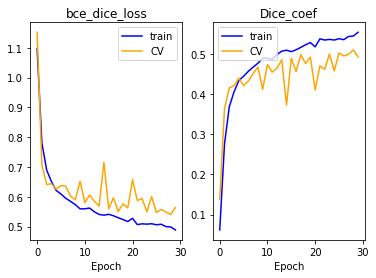

In [0]:
#first 30 epochs
plot(history)

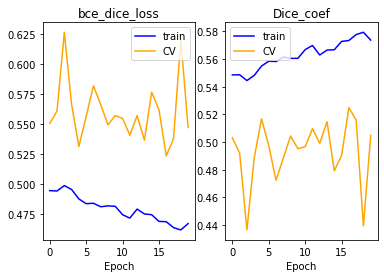

In [0]:
#next 20 epochs
plot(history)

### Tensorboard images

![alt text](https://drive.google.com/uc?id=1VtsEq2k8kSqAx3VNdyBtCzpUn8k_Y7vh)

![alt text](https://drive.google.com/uc?id=1GF0TiUCJCKp8LjdFzkkYhJkZeKwjeAG6)

![alt text](https://drive.google.com/uc?id=1itGRDqClUu3g1lNovet0ePpbBlc6-KC3)

## 2.4 Model Testing

### Loading the best model for evaluation

** Considering the best model which was trained on 30 epochs as the model in the next 20 epochs experienced the problem of overfitting.**

In [0]:
from keras.models import load_model
dependencies = {'bce_dice_loss':bce_dice_loss,'dice_coef':dice_coef,}
model_best = load_model('/content/best_model_segnet.h5',custom_objects=dependencies)

### Evaluating on validation images

In [0]:
evals= model_best.evaluate(valid_batches,verbose=1)

117/117 [==============================] - 31s 261ms/step


In [0]:
print('Validation set evaluation score:')
print('bce_dice loss:',evals[0])
print('dice_coeff:',evals[1])

Validation set evaluation score:
bce_dice loss: 0.5403748965925641
dice_coeff: 0.5100375587515171


## 2.5 Defects visualization

**Please refer to the "visualize_defects" function in Utility functions section.**

### Training set

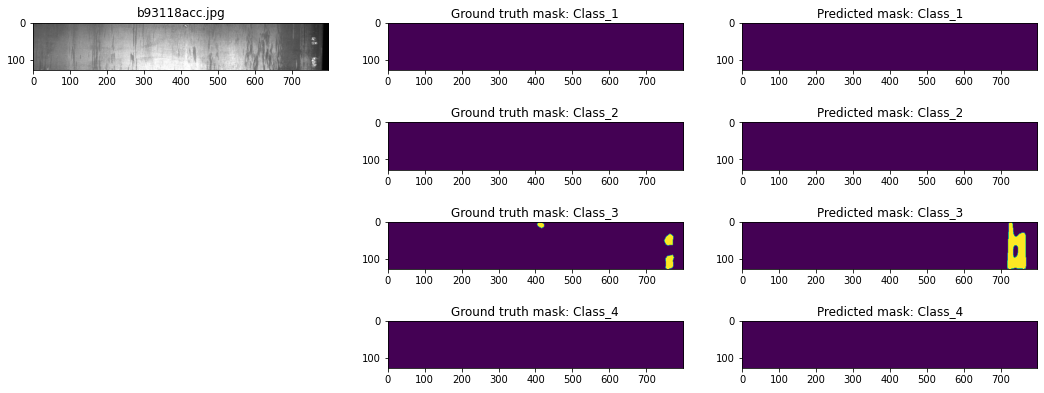

------------------------------------------------------------------------------------------------------------------------------------------------------


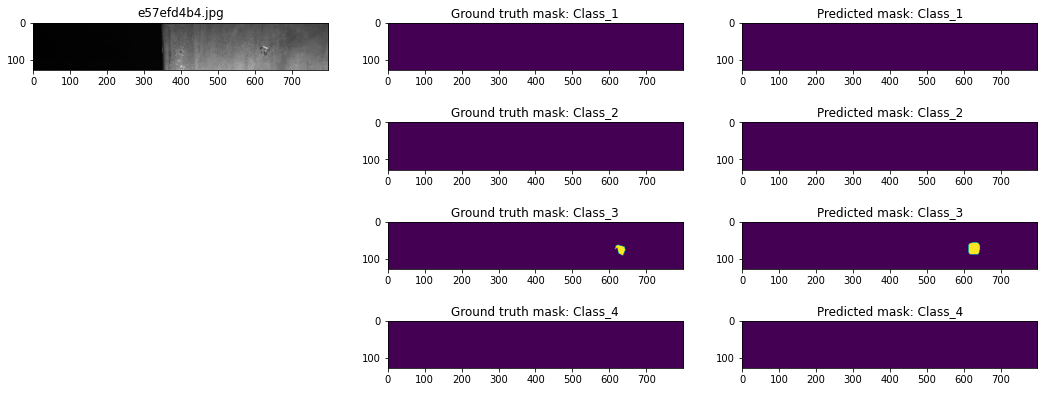

------------------------------------------------------------------------------------------------------------------------------------------------------


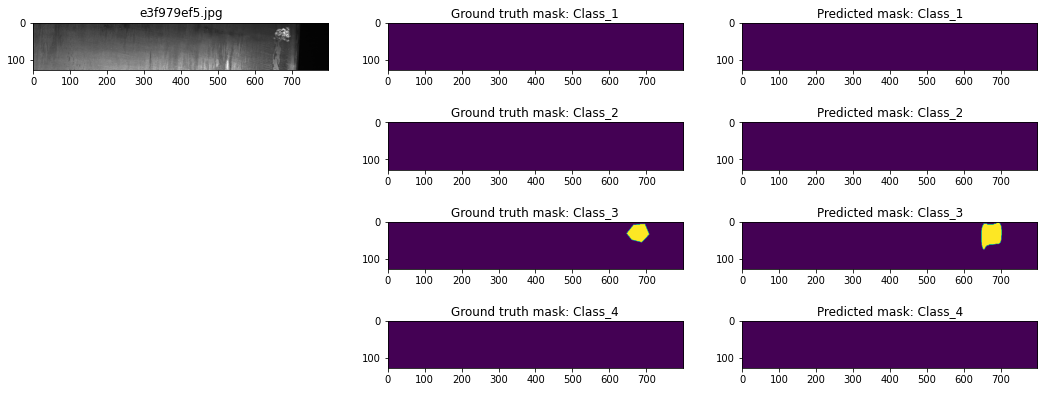

------------------------------------------------------------------------------------------------------------------------------------------------------


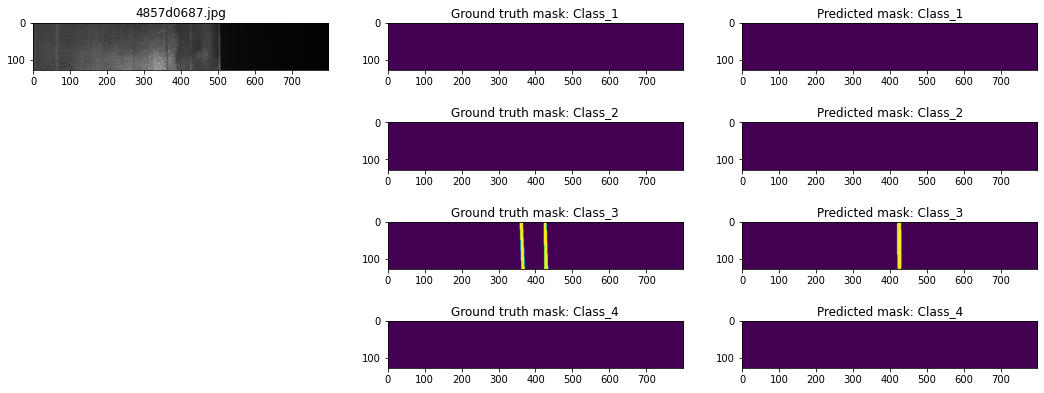

------------------------------------------------------------------------------------------------------------------------------------------------------


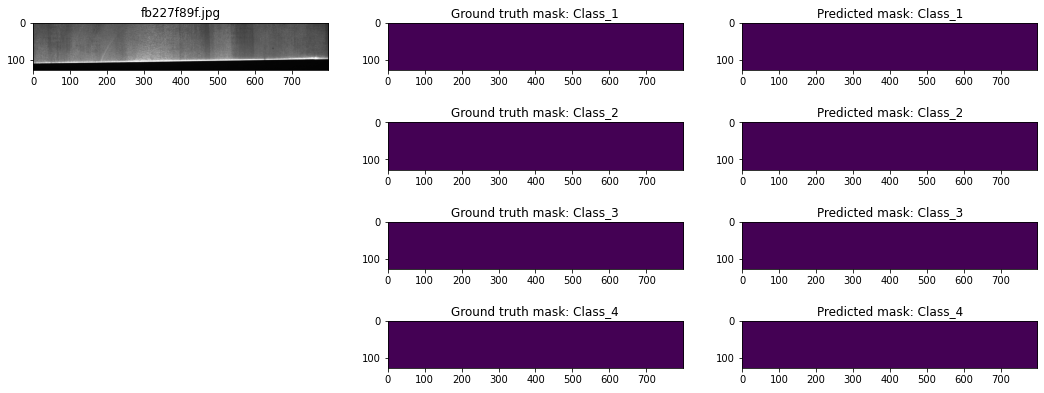

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(train_data,model_best)

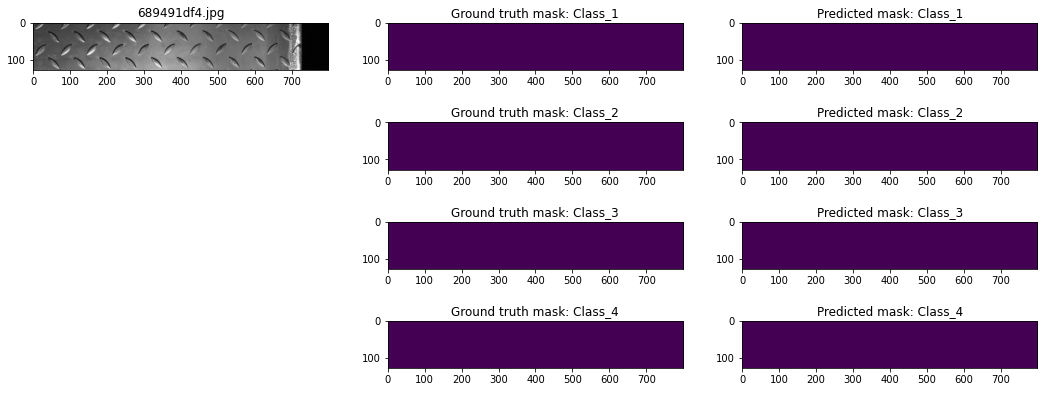

------------------------------------------------------------------------------------------------------------------------------------------------------


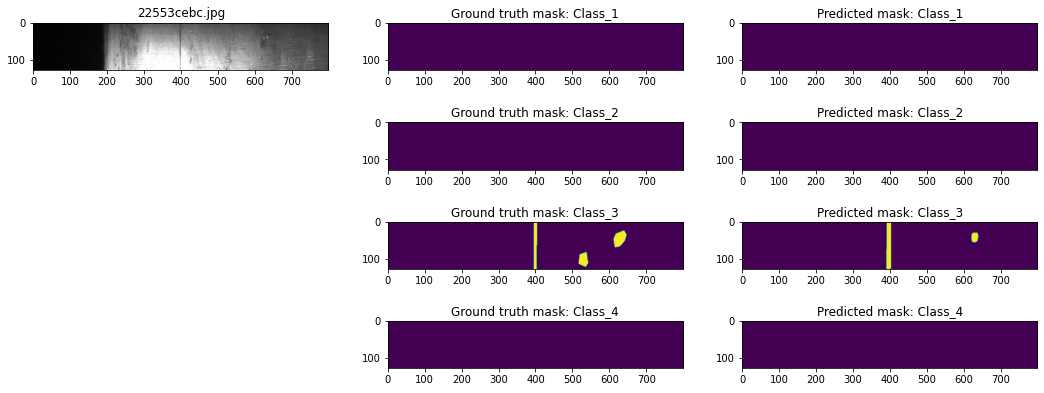

------------------------------------------------------------------------------------------------------------------------------------------------------


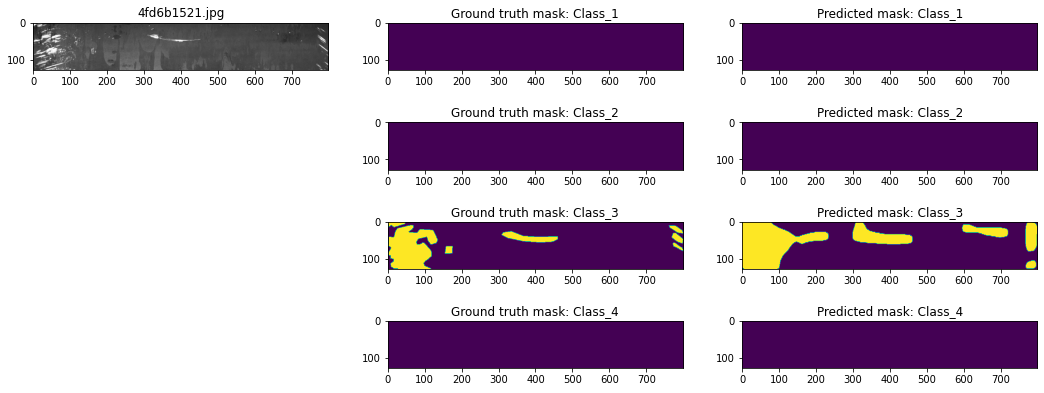

------------------------------------------------------------------------------------------------------------------------------------------------------


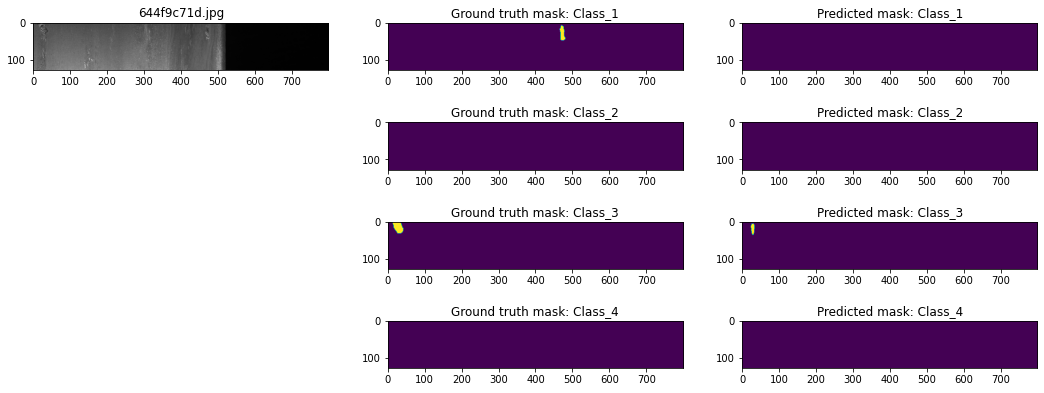

------------------------------------------------------------------------------------------------------------------------------------------------------


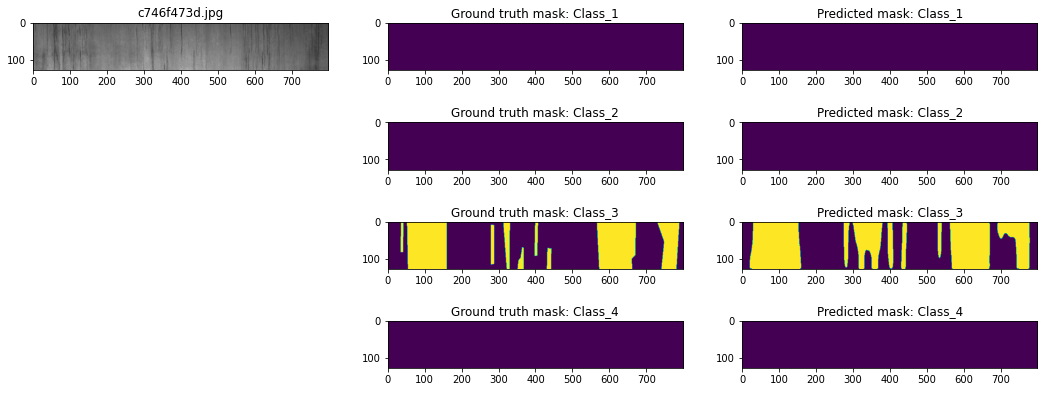

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(train_data,model_best)

### Validation set

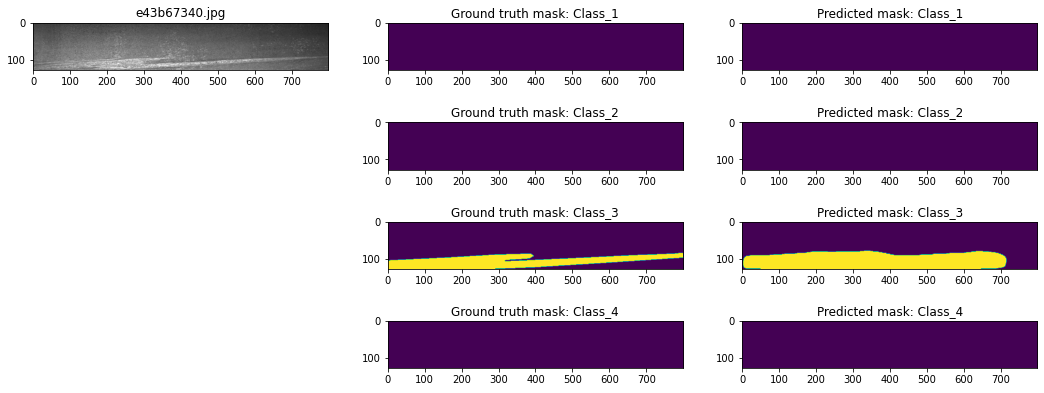

------------------------------------------------------------------------------------------------------------------------------------------------------


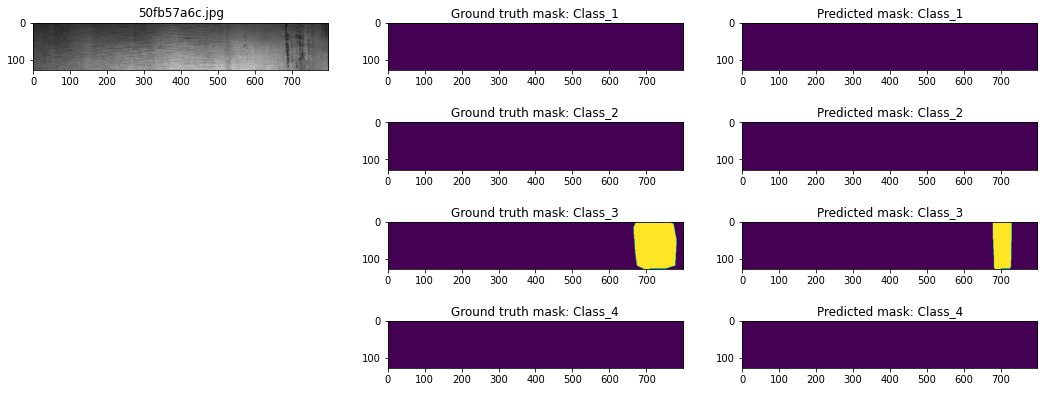

------------------------------------------------------------------------------------------------------------------------------------------------------


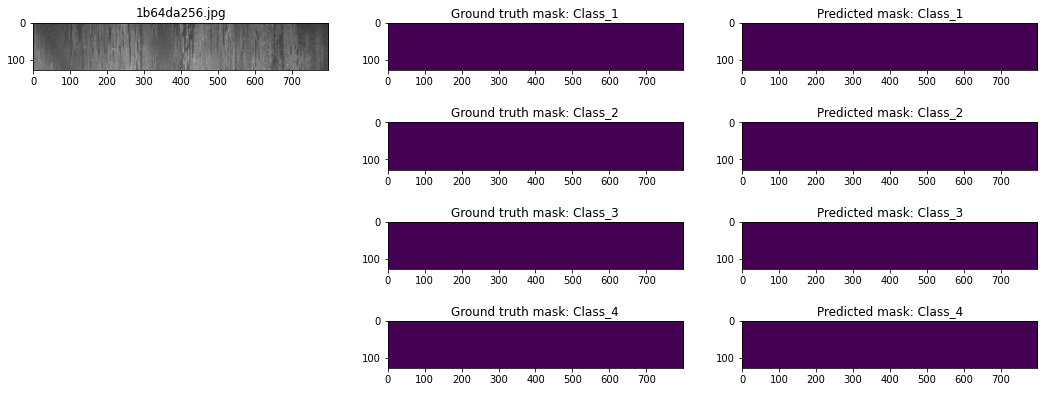

------------------------------------------------------------------------------------------------------------------------------------------------------


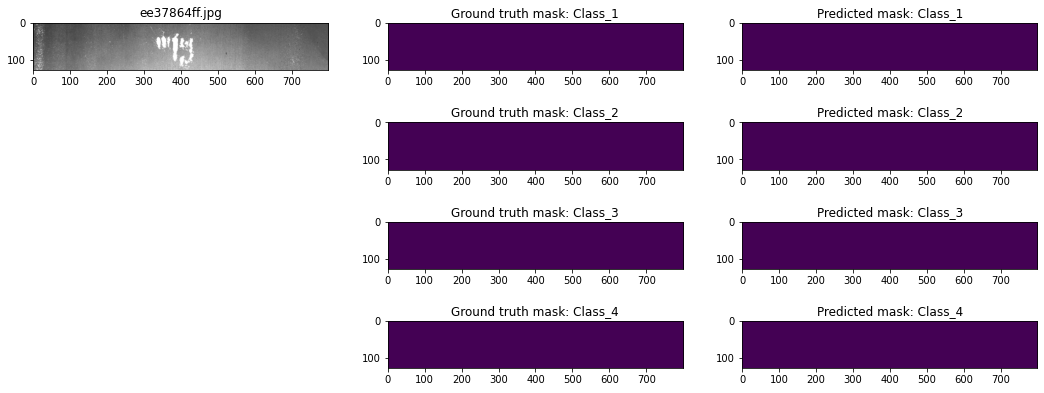

------------------------------------------------------------------------------------------------------------------------------------------------------


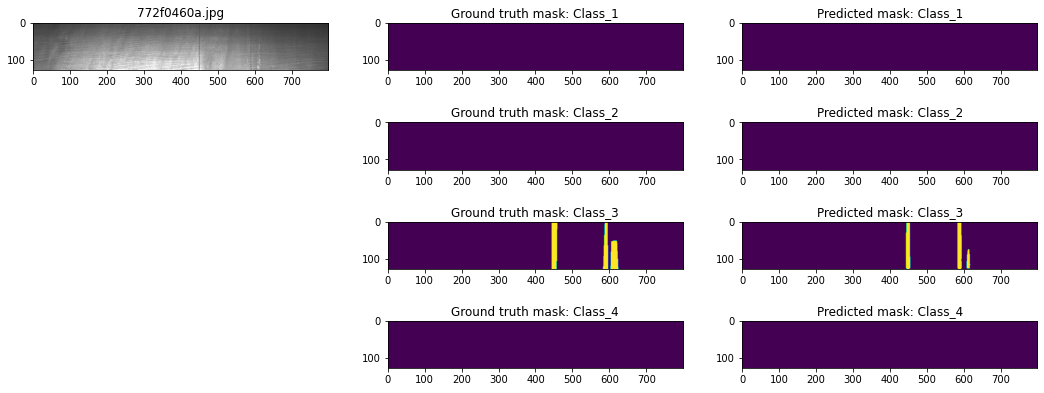

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(cv_data,model_best)

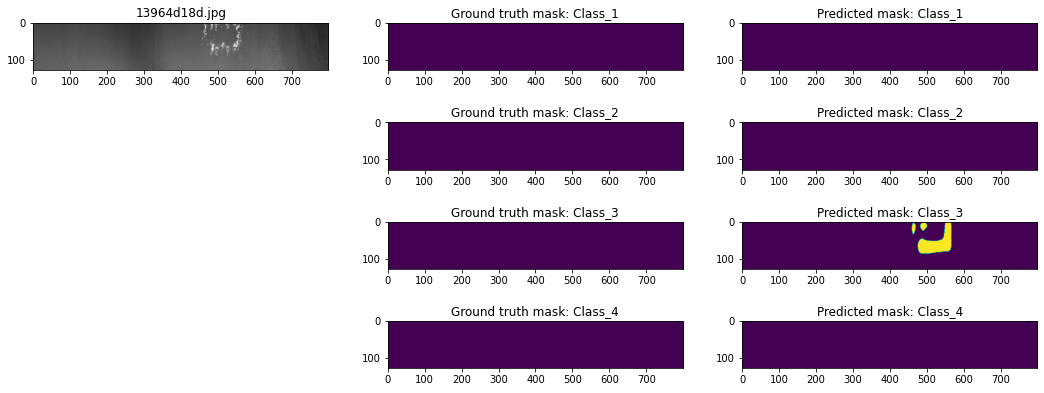

------------------------------------------------------------------------------------------------------------------------------------------------------


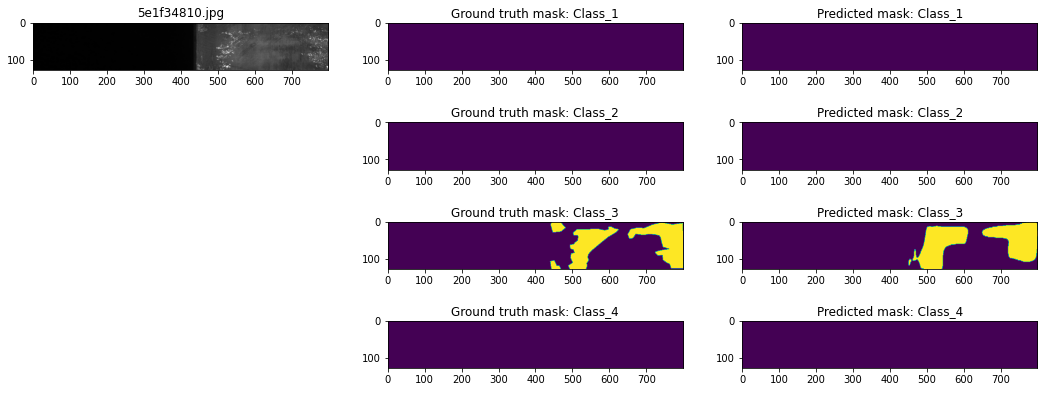

------------------------------------------------------------------------------------------------------------------------------------------------------


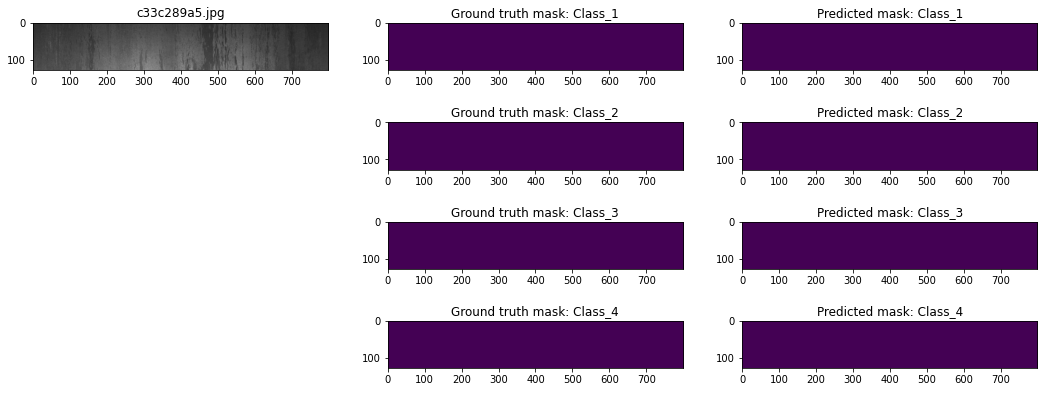

------------------------------------------------------------------------------------------------------------------------------------------------------


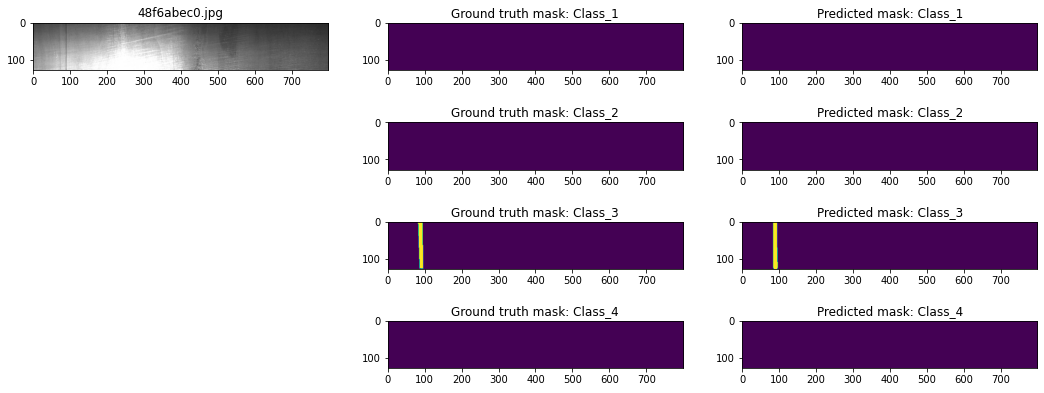

------------------------------------------------------------------------------------------------------------------------------------------------------


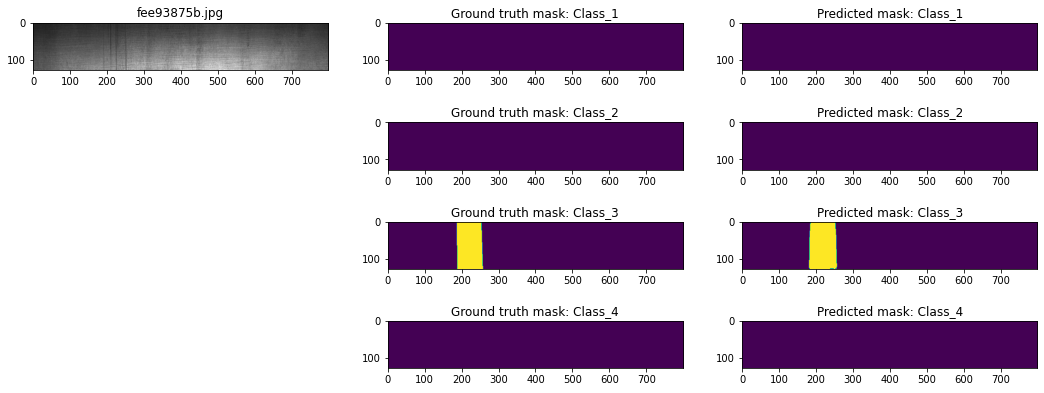

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(cv_data,model_best)

## 2.6 Predicting defects on raw test images

### Redefining the segnet architecture for original image size of 256x1600

In [0]:
input_img = Input((256,1600,3),name='img')
model1 = get_segnet(input_img, n_filters=16, dropout=0.5, batchnorm=True)
model1.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[dice_coef])
model1.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 256, 1600, 3)      0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 256, 1600, 16)     448       
_________________________________________________________________
batch_normalization_101 (Bat (None, 256, 1600, 16)     64        
_________________________________________________________________
activation_101 (Activation)  (None, 256, 1600, 16)     0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 256, 1600, 16)     2320      
_________________________________________________________________
batch_normalization_102 (Bat (None, 256, 1600, 16)     64        
_________________________________________________________________
activation_102 (Activation)  (None, 256, 1600, 16)     0   

In [0]:
model1.set_weights(model_best.get_weights())

### Predicting on full 256x1600 raw test images

In [0]:
# Predicting on test images
from tqdm import tqdm
import cv2
data_path = '/content/' + 'test_images/'
files = list(os.listdir(data_path))
rle_lst = [] #list to store defect in run length encoding format
img_classId= [] #list to store Image ID + classId

for f in tqdm(files):
    X = np.empty((1,256,1600,3),dtype=np.float32)
    img = cv2.imread(data_path + f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X[0,] = img
    mask = model1.predict(X)
    rle_m = np.empty((256,1600),dtype=np.uint8)
    for i in range(4):
        rle_m = mask[0,:,:,i].round().astype(int)
        rle = mask2rle(rle_m)
        rle_lst.append(rle)
        img_classId.append(f+'_'+str(i+1))

100%|██████████| 5506/5506 [05:19<00:00, 17.21it/s]


In [0]:
output = {'ImageId_ClassId':img_classId, 'EncodedPixels' : rle_lst}
output_df = pd.DataFrame(output)
output_df.to_csv('submission_segnet_256x1600.csv', index=False)

**With this submission, I got a private dice coefficient score of 0.83437 & a public score of 0.84740.**

## 2.7 Visualizing defects of raw test images(256x1600)

**Please refer to the "visualize_defects_test" function in Utility functions section.**

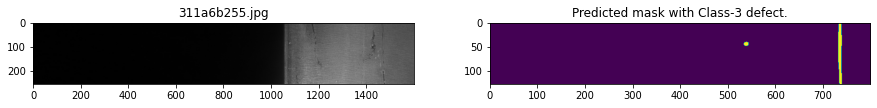

------------------------------------------------------------------------------------------------------------------------------------------------------


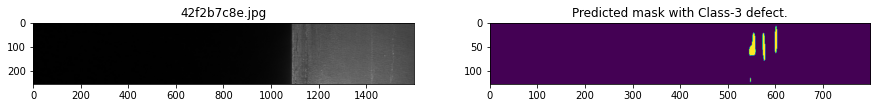

------------------------------------------------------------------------------------------------------------------------------------------------------


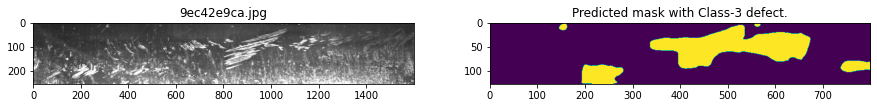

------------------------------------------------------------------------------------------------------------------------------------------------------


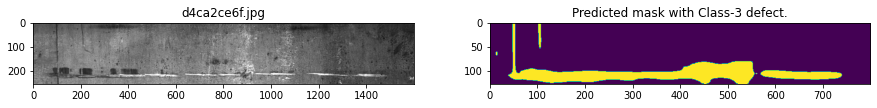

------------------------------------------------------------------------------------------------------------------------------------------------------


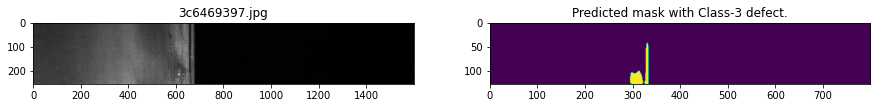

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(output_df,5)

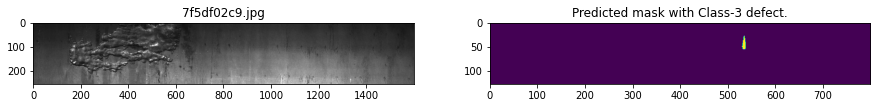

------------------------------------------------------------------------------------------------------------------------------------------------------


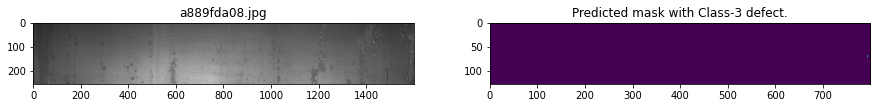

------------------------------------------------------------------------------------------------------------------------------------------------------


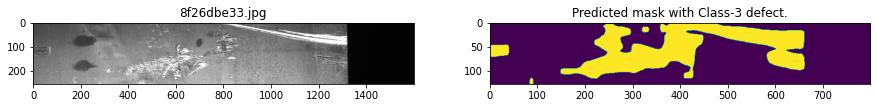

------------------------------------------------------------------------------------------------------------------------------------------------------


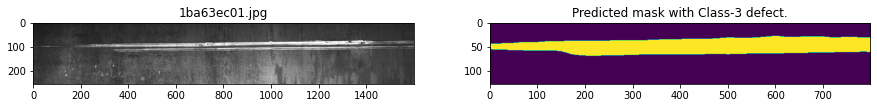

------------------------------------------------------------------------------------------------------------------------------------------------------


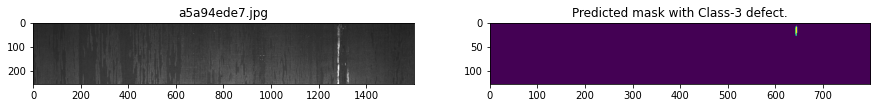

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(output_df,5)

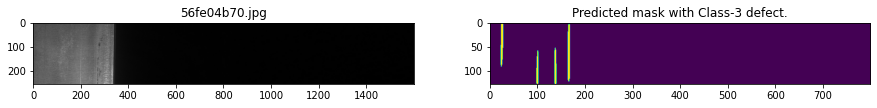

------------------------------------------------------------------------------------------------------------------------------------------------------


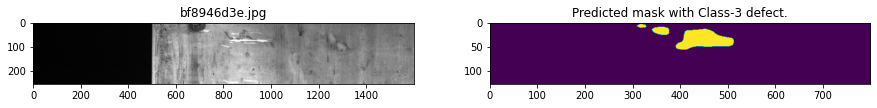

------------------------------------------------------------------------------------------------------------------------------------------------------


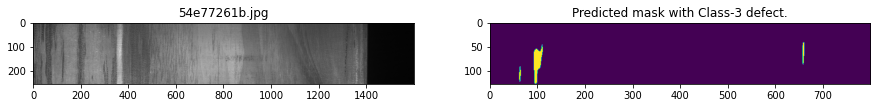

------------------------------------------------------------------------------------------------------------------------------------------------------


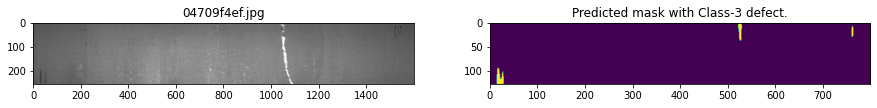

------------------------------------------------------------------------------------------------------------------------------------------------------


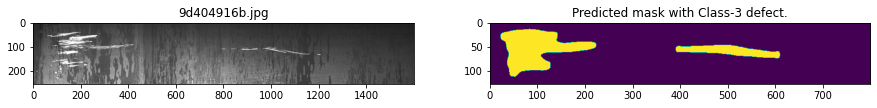

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(output_df,5)

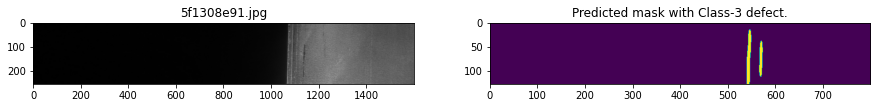

------------------------------------------------------------------------------------------------------------------------------------------------------


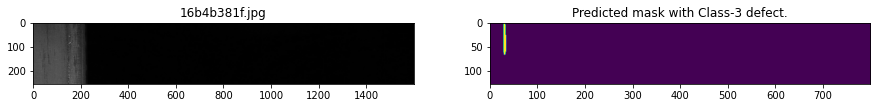

------------------------------------------------------------------------------------------------------------------------------------------------------


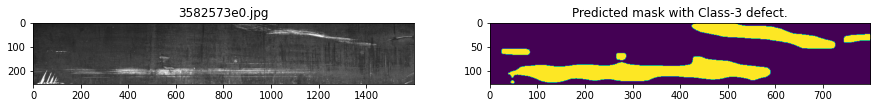

------------------------------------------------------------------------------------------------------------------------------------------------------


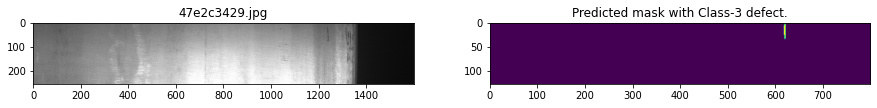

------------------------------------------------------------------------------------------------------------------------------------------------------


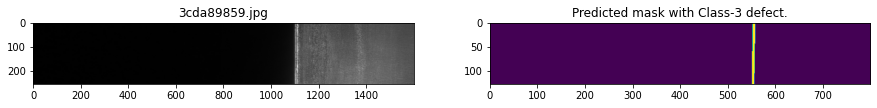

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(output_df,5)

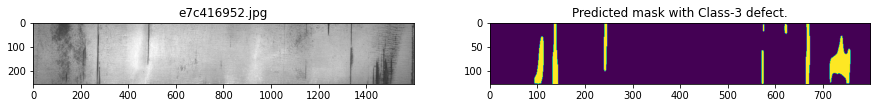

------------------------------------------------------------------------------------------------------------------------------------------------------


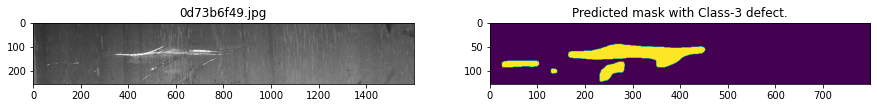

------------------------------------------------------------------------------------------------------------------------------------------------------


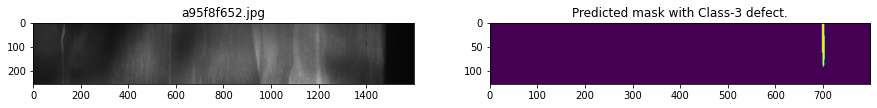

------------------------------------------------------------------------------------------------------------------------------------------------------


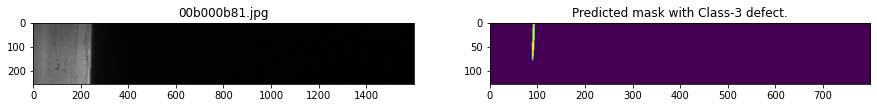

------------------------------------------------------------------------------------------------------------------------------------------------------


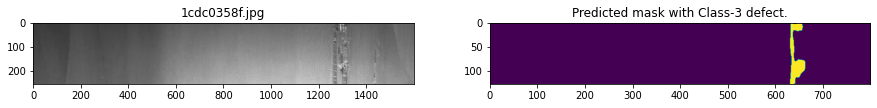

------------------------------------------------------------------------------------------------------------------------------------------------------


In [0]:
visualize_defects(output_df,5)